In [11]:
%matplotlib inline

In [23]:
import pandas as pd
from matplotlib import pyplot as plt

plt.rcParams["figure.figsize"] = (14, 8)

In [17]:
def get_prefixed_filename(prefix, filename):
    return filename if prefix is None else f'{prefix}_{filename}'

def load_simulation_results(name=None):
    filename = get_prefixed_filename(name, 'results.csv')
    return pd.read_csv(filename)

def load_sensitivity_results(variable, name=None):
    filename = get_prefixed_filename(name, f'{variable}_results.csv')
    return pd.read_csv(filename).set_index('parameter')

In [18]:
def barplot(sensitivity_df):
    CONF_COLUMN = '_conf'
    conf_cols = sensitivity_df.columns.str.contains(CONF_COLUMN)

    confs = sensitivity_df.loc[:, conf_cols]
    confs.columns = [c.replace(CONF_COLUMN, '') for c in confs.columns]

    df = sensitivity_df.loc[:, ~conf_cols]

    df.plot(kind='bar', yerr=confs, grid=True)

In [19]:
sdf1 = load_sensitivity_results('recovered')
sdf1

,ST,ST_conf,S1,S1_conf
parameter,,,,
mean_age,1.081913,1.109483,2.009341,2.390899
risk_age,0.010001,1.443765,0.029701,1.936327


In [43]:
rdfa1 = load_simulation_results(name='a2')
sdfa1_dead = load_sensitivity_results(name='a2', variable='dead')
sdfa1_unaf = load_sensitivity_results(name='a2', variable='unaffected')
sdfa1_reco = load_sensitivity_results(name='a2', variable='recovered')
sdfa1_time = load_sensitivity_results(name='a2', variable='timesteps')

In [44]:
rdfa1

,p_mean_age,p_max_age,p_proportion_wearing_masks,p_healthcare_capacity,p_self_isolate_proportion,p_lockdown,p_lockdown_percentage,p_lockdown_compliance,r_timesteps,r_dead,r_recovered,r_infected,r_infectious,r_unaffected
0,34.394531,55.800781,0.518555,169.189453,0.280273,True,0.027720,89.991699,2286,12,436,0,0,52
1,40.019531,55.800781,0.518555,169.189453,0.280273,True,0.027720,89.991699,2312,15,416,0,0,69
2,34.394531,54.160156,0.518555,169.189453,0.280273,True,0.027720,89.991699,1386,19,477,0,0,4
3,34.394531,55.800781,0.084961,169.189453,0.280273,True,0.027720,89.991699,1926,7,455,0,0,38
4,34.394531,55.800781,0.518555,63.720703,0.280273,True,0.027720,89.991699,2427,14,423,0,0,63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,39.248047,85.244141,0.564941,26.000977,0.917480,True,0.082102,6.864502,2235,13,451,0,0,36
996,39.248047,85.244141,0.564941,26.000977,0.971191,True,0.082102,6.864502,2598,16,446,0,0,38
997,39.248047,85.244141,0.564941,26.000977,0.971191,True,0.252258,6.864502,2074,12,453,0,0,35
998,39.248047,85.244141,0.564941,26.000977,0.971191,True,0.082102,41.456299,2242,17,447,0,0,36


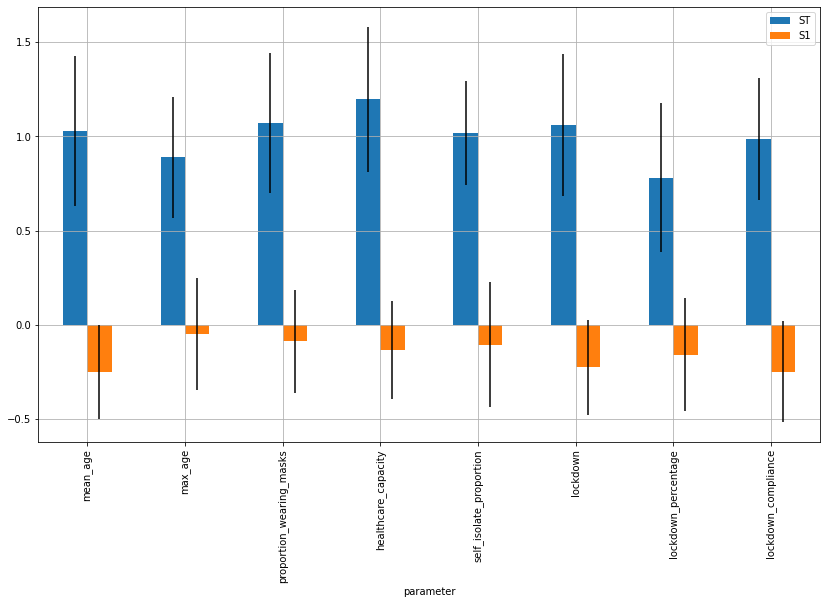

In [45]:
barplot(sdfa1_dead)

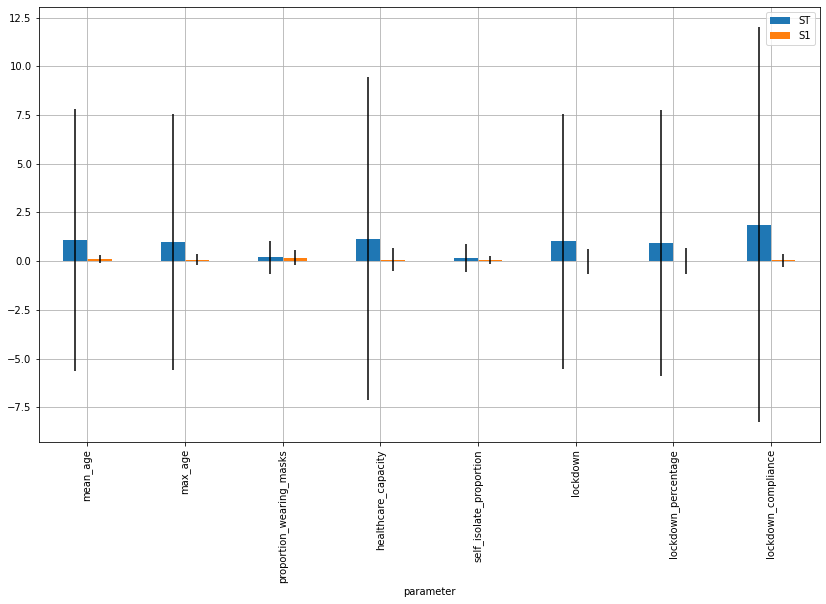

In [46]:
barplot(sdfa1_unaf)

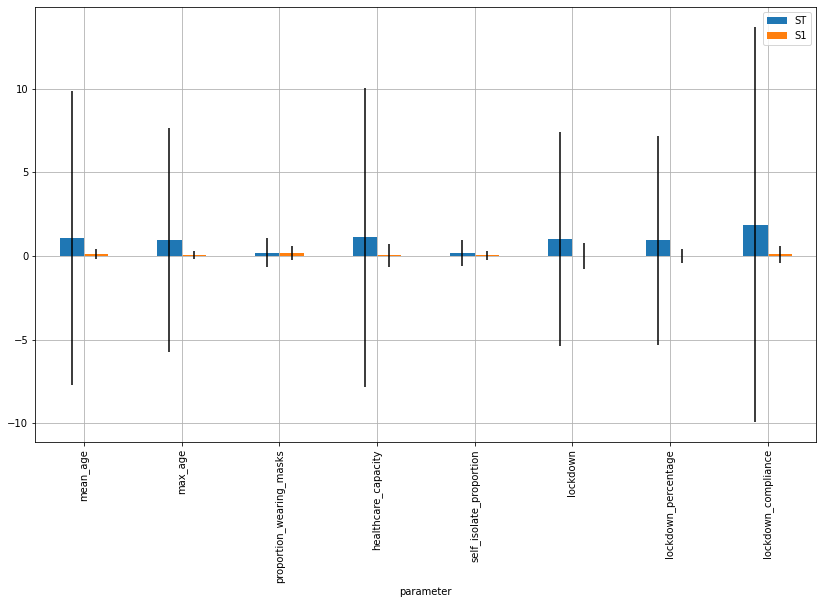

In [47]:
barplot(sdfa1_reco)

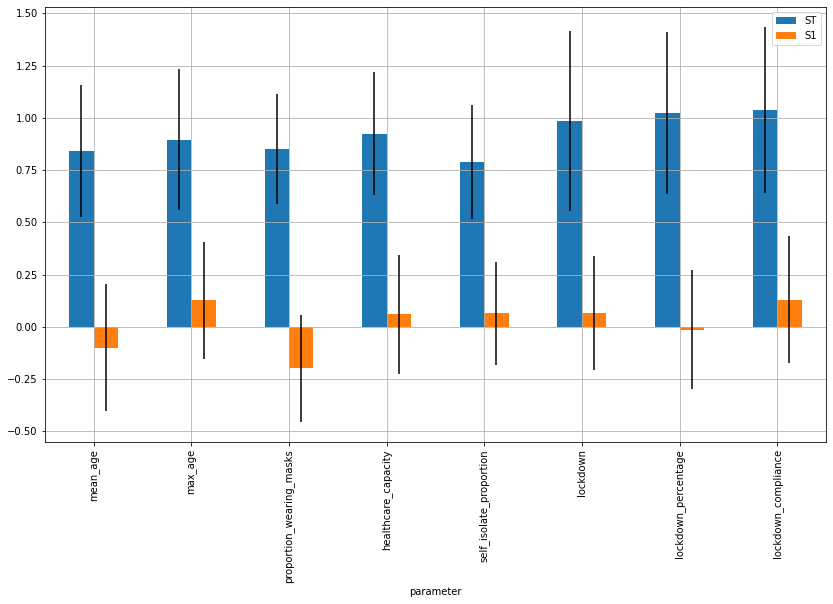

In [48]:
barplot(sdfa1_time)